# Loading necessary libraries and the provided datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_md

2023-12-09 23:43:22.601919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 23:43:22.601991: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 23:43:22.602041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 23:43:22.618778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 23:43:26.161075: W tensorflow/compiler/

In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import json
import spacy

In [ ]:
# with open('/content/dev_matched_sampled-1 (1).jsonl') as f:
#     matched_data = json.load(f)
file = open('/content/dev_matched_sampled-1.jsonl')
matched_data = []
for line in file.readlines():
  dic = json.loads(line)
  matched_data.append(dic)
# with open('/content/dev_mismatched_sampled-1 (1).jsonl') as f:
#     mismatched_data = json.load(f)

file = open('/content/dev_mismatched_sampled-1.jsonl')
mismatched_data = []
for line in file.readlines():
  dic = json.loads(line)
  mismatched_data.append(dic)

In [ ]:
matched = pd.DataFrame(matched_data)
mismatched = pd.DataFrame(mismatched_data)

In [ ]:
print(matched.shape)
print(mismatched.shape)

(2500, 11)
(2500, 11)


<Axes: xlabel='gold_label', ylabel='count'>

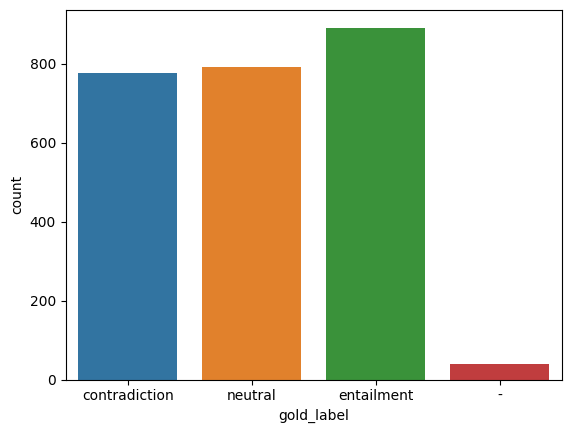

In [ ]:
import seaborn as sns

# Assuming "df" is your DataFrame and "column_name" is the column containing the categorical variable
sns.countplot(data=matched, x="gold_label")

In [ ]:
sns.countplot(data=mismatched, x="gold_label")

# Task 2.1 Prompting Approach

## 2.1 (i) constructing an input query x that will be submitted to the language model

According to https://stanford-cs324.github.io/winter2022/lectures/capabilities/, we can frame the task in to a multple-choice task.

Based on the recommended framework, which contains the question, and the choice options in its suggested prompts, I've constructed the prompt below:

```
Context:
1: {sentence1};
2: {sentence2}

Question: What is relationsip between two sentences?

Select one from "Entailment", "Neutral", "Contradiction" as answer only.

Answer:
```

In [ ]:
def format_prompt(row, prompt):
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    return prompt.format(sentence1=sentence1, sentence2=sentence2).replace("\n", "")

In [ ]:
nlp = spacy.load("en_core_web_md")

def verbalizer_simple(row, label):
  text = row[label].lower()
  if "contradict" in text:
    return "Contradiction"
  elif "neutral" in text:
    return "Neutral"
  return "Entailment"

def verbalizer_simple2(row, label):
  text = row[label].lower()
  if "entail" in text:
    return "Entailment"
  elif "contradict" in text:
    return "Contradiction"
  return "Neutral"

def verbalizer_complex(row, label):
  text = row[label].lower()
  options = ["Entailment", "Contradiction", "Neutral"]
  similarity_scores = []
  for option in options:
      option_doc = nlp(option.lower())
      text_doc = nlp(text)
      similarity_score = option_doc.similarity(text_doc)
      similarity_scores.append(similarity_score)
  most_similar_option = options[similarity_scores.index(max(similarity_scores))]
  return most_similar_option

### Experiment with GPT 2

In [ ]:
prompt = """Context: 1: {sentence1}; 2: {sentence2} Question: What is relationsip between two sentences? Select one from "Entailment", "Neutral", "Contradiction" as answer only. Answer: """

In [ ]:
matched['prompt'] = matched.apply(lambda row: format_prompt(row, prompt), axis=1)

In [ ]:
mismatched['prompt'] = mismatched.apply(lambda row: format_prompt(row, prompt), axis=1)

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Specifying the decode hyperparameters

In [ ]:
model.config.temperature = 0.5
model.config.length_penalty = 1.0
model.config.min_length = 0
model.config.max_length = 20
model.config.num_beams = 1
model.config.top_k = 50
model.config.top_p = 1
model.config.no_repeat_ngram_size = 0

#### Test with one prompt

In [ ]:
input_text = matched['prompt'][0]
inputs = tokenizer.encode(input_text, return_tensors='pt')
outputs = model.generate(inputs, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5025

In [ ]:
print(answer.split("\n")[0])

Context: 1: oh that sounds interesting too; 2: That is not very attention grabbing.  Question: What is relationsip between two sentences? Select one from "Entailment", "Neutral", "Contradiction" as answer only. Answer:  "Neutrino" is the first sentence. Question 2 : What does "entail" mean?  Select two from the list of "Negative" and "Positive" sentences. The first is "I


### Generating classified class using gpt2

In [ ]:
def generate_answer_using_gpt2(row, sentence=False):
  if sentence:
    inputs = tokenizer.encode(row, return_tensors='pt')
    outputs = model.generate(inputs, max_length=150, num_return_sequences=1, no_repeat_ngram_size=2)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    start_index = answer.split("\n")[0].find("Answer:")
    footstop = answer.split("\n")[0][start_index:].find(".")
    return answer.split("\n")[0][start_index:start_index+footstop]
  input_text = row['prompt']
  inputs = tokenizer.encode(input_text, return_tensors='pt')
  outputs = model.generate(inputs, max_length=150, num_return_sequences=1, no_repeat_ngram_size=2)
  answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
  start_index = answer.split("\n")[0].find("Answer:")
  footstop = answer.split("\n")[0][start_index:].find(".")
  return answer.split("\n")[0][start_index:start_index+footstop]

In [ ]:
matched["gpt2_generated_uncleaned"] = matched.apply(lambda row: generate_answer_using_gpt2(row), axis=1)

In [ ]:
mismatched["gpt2_generated_uncleaned"] = mismatched.apply(lambda row: generate_answer_using_gpt2(row), axis=1)

In [ ]:
matched = pd.read_csv("/content/matched_gpt2_generated.csv")
mismatched = pd.read_csv("/content/mismatched_gpt2_generated.csv")

In [ ]:
matched = matched[matched["gpt2_generated_uncleaned"].notna()]
mismatched = mismatched[mismatched["gpt2_generated_uncleaned"].notna()]

In [ ]:
matched["predictions_gpt2_simple"] = matched.apply(lambda row: verbalizer_simple(row, "gpt2_generated_uncleaned"), axis=1)
matched["predictions_gpt2_simple2"] = matched.apply(lambda row: verbalizer_simple2(row, "gpt2_generated_uncleaned"), axis=1)
matched["predictions_gpt2_complex"] = matched.apply(lambda row: verbalizer_complex(row, "gpt2_generated_uncleaned"), axis=1)


In [ ]:
mismatched["predictions_gpt2_simple"] = matched.apply(lambda row: verbalizer_simple(row, "gpt2_generated_uncleaned"), axis=1)
mismatched["predictions_gpt2_simple2"] = matched.apply(lambda row: verbalizer_simple2(row, "gpt2_generated_uncleaned"), axis=1)
mismatched["predictions_gpt2_complex"] = matched.apply(lambda row: verbalizer_complex(row, "gpt2_generated_uncleaned"), axis=1)

In [ ]:
matched.to_csv("/content/matched_gpt2_verbalized.csv")
mismatched.to_csv("/content/mismatched_gpt2_verbalized.csv")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
matched_filtered = matched[matched["gold_label"] != "-"]
true = matched_filtered["gold_label"].str.lower()
predicted = matched_filtered["predictions_gpt2_simple"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for simple verbalizer is:", accuracy)
print("Precision of mismatched data for simple verbalizer is:", precision)
print("Recall of mismatched data for simple verbalizer is:", recall)
print("F1 score of mismatched data for simple verbalizer is:", f1)

predicted = matched_filtered["predictions_gpt2_simple2"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for simple verbalizer 2 is:", accuracy)
print("Precision of mismatched data for simple verbalizer 2 is:", precision)
print("Recall of mismatched data for simple verbalizer 2 is:", recall)
print("F1 score of mismatched data for simple verbalizer 2 is:", f1)


predicted = matched_filtered["predictions_gpt2_complex"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for complex verbalizer is:", accuracy)
print("Precision of mismatched data for complex  verbalizer is:", precision)
print("Recall of mismatched data for complex  verbalizer is:", recall)
print("F1 score of mismatched data for complex  verbalizer is:", f1)

Accuracy of mismatched data for simple verbalizer is: 0.3480691056910569
Precision of mismatched data for simple verbalizer is: 0.278672247323878
Recall of mismatched data for simple verbalizer is: 0.3480691056910569
F1 score of mismatched data for simple verbalizer is: 0.21940794055766388
Accuracy of mismatched data for simple verbalizer 2 is: 0.3170731707317073
Precision of mismatched data for simple verbalizer 2 is: 0.3220179172340723
Recall of mismatched data for simple verbalizer 2 is: 0.3170731707317073
F1 score of mismatched data for simple verbalizer 2 is: 0.20383989841300987
Accuracy of mismatched data for complex verbalizer is: 0.3175813008130081
Precision of mismatched data for complex  verbalizer is: 0.4572048644614078
Recall of mismatched data for complex  verbalizer is: 0.3175813008130081
F1 score of mismatched data for complex  verbalizer is: 0.23944741163228422


In [ ]:
mismatched_filtered = mismatched[mismatched["gold_label"] != "-"]
true = mismatched_filtered["gold_label"].str.lower()
predicted = mismatched_filtered["predictions_gpt2_simple"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for simple verbalizer  is:", accuracy)
print("Precision of mismatched data for simple verbalizer is:", precision)
print("Recall of mismatched data for simple verbalizer is:", recall)
print("F1 score of mismatched data for simple verbalizer is:", f1)

predicted = mismatched_filtered["predictions_gpt2_simple2"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for simple verbalizer 2 is:", accuracy)
print("Precision of mismatched data for simple verbalizer 2 is:", precision)
print("Recall of mismatched data for simple verbalizer 2 is:", recall)
print("F1 score of mismatched data for simple verbalizer 2 is:", f1)


predicted = mismatched_filtered["predictions_gpt2_complex"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for complex verbalizer is:", accuracy)
print("Precision of mismatched data for complex  verbalizer is:", precision)
print("Recall of mismatched data for complex  verbalizer is:", recall)
print("F1 score of mismatched data for complex  verbalizer is:", f1)


Accuracy of mismatched data for simple verbalizer  is: 0.3461794019933555
Precision of mismatched data for simple verbalizer is: 0.3510161250555576
Recall of mismatched data for simple verbalizer is: 0.3461794019933555
F1 score of mismatched data for simple verbalizer is: 0.22024536341296874
Accuracy of mismatched data for simple verbalizer 2 is: 0.34485049833887044
Precision of mismatched data for simple verbalizer 2 is: 0.37626420033630703
Recall of mismatched data for simple verbalizer 2 is: 0.34485049833887044
F1 score of mismatched data for simple verbalizer 2 is: 0.23028896415967354
Accuracy of mismatched data for complex verbalizer is: 0.320265780730897
Precision of mismatched data for complex  verbalizer is: 0.4434061916843837
Recall of mismatched data for complex  verbalizer is: 0.320265780730897
F1 score of mismatched data for complex  verbalizer is: 0.2409377093529598


### Experimenting with FLAN-T5

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
t5model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Specifying decode hyperparameters

In [ ]:
t5model.config.temperature = 1.0
t5model.config.length_penalty = 1.0
t5model.config.min_length = 0
t5model.config.max_length = 20
t5model.config.num_beams = 1

In [ ]:
prompt = """ Answer one of "Entailed", "Contradicted","Netral" as answer only.  Choose the best option to describe the relationship between the two sentence: 1 - {sentence1}; 2 - {sentence2} """

### Generating Prompts with FLAN T5

```
Answer one of "Entailed", "Contradicted","Netral" as answer only.  

Question: Choose the best option to describe the relationship between the two sentence.


Consider the two sentences:
1: {sentence1}
2: {sentence2}
```

In [ ]:
prompt = """ Answer one of "Entailed", "Contradicted","Netral" as answer only.  Choose the best option to describe the relationship between the two sentence: 1 - {sentence1}; 2 - {sentence2} """

In [ ]:
matched['prompt'] = matched.apply(lambda row: format_prompt(row, prompt), axis=1)

In [ ]:
mismatched['prompt'] = mismatched.apply(lambda row: format_prompt(row, prompt), axis=1)

In [ ]:
count = 0
def generate_answer_using_t5(row):
  global count
  sentence = row["prompt"]
  inputs = tokenizer(sentence, return_tensors="pt")
  outputs = t5model.generate(**inputs, max_new_tokens=50)
  result = tokenizer.batch_decode(outputs, skip_special_tokens=True)
  count += 1
  print(count)
  return result

In [ ]:
matched["t5_generated_uncleaned"] = matched.apply(lambda row: generate_answer_using_t5(row), axis=1)

In [ ]:
mismatched["t5_generated_uncleaned"] = mismatched.apply(lambda row: generate_answer_using_t5(row), axis=1)

In [ ]:
matched["predictions_t5_simple"] = matched.apply(lambda row: verbalizer_simple(row, "t5_generated_uncleaned"), axis=1)
matched["predictions_t5_simple2"] = matched.apply(lambda row: verbalizer_simple2(row, "t5_generated_uncleaned"), axis=1)
matched["predictions_t5_complex"] = matched.apply(lambda row: verbalizer_complex(row, "t5_generated_uncleaned"), axis=1)

In [ ]:
mismatched["predictions_t5_simple"] = mismatched.apply(lambda row: verbalizer_simple(row, "t5_generated_uncleaned"), axis=1)
mismatched["predictions_t5_simple2"] = mismatched.apply(lambda row: verbalizer_simple2(row, "t5_generated_uncleaned"), axis=1)
mismatched["predictions_t5_complex"] = mismatched.apply(lambda row: verbalizer_complex(row, "t5_generated_uncleaned"), axis=1)

In [ ]:
matched.to_csv("/content/matched_verbalized.csv")
mismatched.to_csv("/content/mimatched_verbalized.csv")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
matched_filtered = matched[matched["gold_label"] != "-"]
true = matched_filtered["gold_label"].str.lower()
predicted = matched_filtered["predictions_t5_simple"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of matched data for simple verbalizer is:", accuracy)
print("Precision of matched data for simple verbalizer is:", precision)
print("Recall of matched data for simple verbalizer is:", recall)
print("F1 score of matched data for simple verbalizer is:", f1)

predicted = matched_filtered["predictions_t5_simple2"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for simple verbalizer 2 is:", accuracy)
print("Precision of mismatched data for simple verbalizer 2 is:", precision)
print("Recall of mismatched data for simple verbalizer 2 is:", recall)
print("F1 score of mismatched data for simple verbalizer 2 is:", f1)


predicted = matched_filtered["predictions_t5_complex"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for complex verbalizer is:", accuracy)
print("Precision of mismatched data for complex verbalizer is:", precision)
print("Recall of mismatched data for complex verbalizer is:", recall)
print("F1 score of mismatched data for complex verbalizer is:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of matched data for simple verbalizer is: 0.6316056910569106
Precision of matched data for simple verbalizer is: 0.4318456829400485
Recall of matched data for simple verbalizer is: 0.6316056910569106
F1 score of matched data for simple verbalizer is: 0.5119629571073508
Accuracy of mismatched data for simple verbalizer 2 is: 0.5132113821138211
Precision of mismatched data for simple verbalizer 2 is: 0.4980744284260834
Recall of mismatched data for simple verbalizer 2 is: 0.5132113821138211
F1 score of mismatched data for simple verbalizer 2 is: 0.4780518490562357
Accuracy of mismatched data for complex verbalizer is: 0.3231707317073171
Precision of mismatched data for complex verbalizer is: 0.1044393218322427
Recall of mismatched data for complex verbalizer is: 0.3231707317073171
F1 score of mismatched data for complex verbalizer is: 0.15786220074182308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mismatched_filtered = mismatched[mismatched["gold_label"] != "-"]
true = mismatched_filtered["gold_label"].str.lower()
predicted = mismatched_filtered["predictions_t5_simple"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for simple verbalizer is:", accuracy)
print("Precision of mismatched data for simple verbalizer is:", precision)
print("Recall of mismatched data for simple verbalizer is:", recall)
print("F1 score of mismatched data for simple verbalizer is:", f1)

predicted = mismatched_filtered["predictions_t5_simple2"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for simple verbalizer 2 is:", accuracy)
print("Precision of mismatched data for simple verbalizer 2 is:", precision)
print("Recall of mismatched data for simple verbalizer 2 is:", recall)
print("F1 score of mismatched data for simple verbalizer 2 is:", f1)


predicted = mismatched_filtered["predictions_t5_complex"].str.lower()
accuracy = accuracy_score(true, predicted)
precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
f1 = f1_score(true, predicted, average='weighted')
print("Accuracy of mismatched data for complex verbalizer is:", accuracy)
print("Precision of mismatched data for complex verbalizer is:", precision)
print("Recall of mismatched data for complex verbalizer is:", recall)
print("F1 score of mismatched data for complex verbalizer is:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of mismatched data for simple verbalizer is: 0.6273258904837852
Precision of mismatched data for simple verbalizer is: 0.4200437428141693
Recall of mismatched data for simple verbalizer is: 0.6273258904837852
F1 score of mismatched data for simple verbalizer is: 0.5027621710645394
Accuracy of mismatched data for simple verbalizer 2 is: 0.5050505050505051
Precision of mismatched data for simple verbalizer 2 is: 0.4910344861161254
Recall of mismatched data for simple verbalizer 2 is: 0.5050505050505051
F1 score of mismatched data for simple verbalizer 2 is: 0.46824085964408024
Accuracy of mismatched data for complex verbalizer is: 0.32216905901116427
Precision of mismatched data for complex verbalizer is: 0.10379290258413905
Recall of mismatched data for complex verbalizer is: 0.32216905901116427
F1 score of mismatched data for complex verbalizer is: 0.15700398050725012


# Section 3: Exploring biases


In [ ]:
!git clone https://github.com/nyu-mll/crows-pairs.git

Cloning into 'crows-pairs'...
remote: Enumerating objects: 904, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 904 (delta 81), reused 170 (delta 77), pack-reused 728
Receiving objects: 100% (904/904), 24.59 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (507/507), done.


In [ ]:
!cd crows-pairs && pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement torch==1.4.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1)
ERROR: No matching distribution found for torch==1.4.0


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/crows-pairs/data/crows_pairs_anonymized.csv")

In [ ]:
df_filtered = df[df["bias_type"]== "socioeconomic"]
sampled_df = df_filtered.sample(n=80, random_state=42)

In [ ]:
sampled_df.to_csv("/content/sampled.csv")

### Experimenting with Bert-based (in original codebase)

In [ ]:
!python /content/crows-pairs/metric.py --input_file /content/sampled.csv --lm_model bert --output_file bert_output.csv

python3: can't open file '/content/crows-pairs/metric.py': [Errno 2] No such file or directory


### Experimenting with Bert-Large with adjusted decode hyperparameters (added by me)

In [ ]:
!python /content/crows-pairs/metric.py --input_file /content/sampled.csv --lm_model bert_large --output_file bert_large_output.csv

Evaluating:
Input: /content/sampled.csv
Model: bert_large
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: 

### Experimenting with Roberta-large model (in orginal code base)

In [ ]:
!python /content/crows-pairs/metric.py --input_file /content/sampled.csv --lm_model roberta_large --output_file roberta_large_output.csv

Evaluating:
Input: /content/sampled.csv
Model: roberta_large
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarnin

### Experimenting with Roberta-base with adjusted decode hyperparameters (added by me)

In [ ]:
!python /content/crows-pairs/metric.py --input_file /content/sampled.csv --lm_model roberta_base --output_file roberta_base_output.csv

Evaluating:
Input: /content/sampled.csv
Model: roberta_base
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(df_item, ignore_index=True)
/content/crows-pairs/metric.py:45: FutureWarning

In [ ]:
from google.colab import files

# Download a file
files.download('/content/matched_gpt2_generated.csv')

In [ ]:
!zip -r /content/crows-pairs.zip /content/crows-pairs/

  adding: content/crows-pairs/ (stored 0%)
  adding: content/crows-pairs/data/ (stored 0%)
  adding: content/crows-pairs/data/prompts.csv (deflated 59%)
  adding: content/crows-pairs/data/crows_pairs_anonymized.csv (deflated 79%)
  adding: content/crows-pairs/data/README.md (deflated 54%)
  adding: content/crows-pairs/metric.py (deflated 71%)
  adding: content/crows-pairs/mturk/ (stored 0%)
  adding: content/crows-pairs/mturk/_layouts/ (stored 0%)
  adding: content/crows-pairs/mturk/_layouts/validation.html (deflated 51%)
  adding: content/crows-pairs/mturk/_layouts/stereoset-validation.html (deflated 51%)
  adding: content/crows-pairs/mturk/hit_layouts/ (stored 0%)
  adding: content/crows-pairs/mturk/hit_layouts/instructions.html (deflated 73%)
  adding: content/crows-pairs/mturk/hit_layouts/validationLayout.html (deflated 72%)
  adding: content/crows-pairs/mturk/hit_layouts/validationLayoutStereo.html (deflated 69%)
  adding: content/crows-pairs/mturk/faq/ (stored 0%)
  adding: conte